In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

# Constants for grid and fire simulation
BURNSITE_SIZE = 50  # 10x10 grid cells
EACH_CELL_LENGTH = 10  # Length of each cell in meters
FIRE_SPREAD_PROB = 0.9  # Probability of spreading to neighboring cells (can be less than 1 for stochastic spread)
LOITER_TIME = 2
plausible_time = [16, 18, 20, 22, 24]  # Possible times for fire to burn out
EPOCH_LENGTH = 10
SIMULATION_TIME = 80
POINTS_TO_START_FIRE = [542, 1590]
GAMMA = 6
H_MIN = 10
H_MAX = 120
TASK_PENALTY = 5
DEPOT = (0, 0, 0)
GC_POSITION = (0, 0)


# Dictionary to track the time a cell started burning and its burnout time
burnout_times = {}

# Fire status
# 0: No fire
# 1: Fire starting
# 2: Fire spreading
# 3: Burnt out
# -1: UK, 0: NB, 1/2:B, 3:BO

def initialize_grid(grid_size):
    """
    Initialize the grid with no fire (all cells set to 0).
    """
    grid = np.zeros((grid_size, grid_size), dtype=int)  # All cells start with no fire (0)
    return grid

def start_fire(grid, points):
    """
    Randomly start fire at `num_points` locations in the grid.
    """
    for point in points:
        grid[point // BURNSITE_SIZE][point % BURNSITE_SIZE] = 1  # Set initial fire cells (1 = Fire starting)
    return grid

def spread_fire(grid, step):
    """
    Spread the fire to neighboring cells. Fire spreads to adjacent cells (up, down, left, right).
    Cells will burn for a random duration chosen from plausible_time before burning out.
    """
    new_grid = grid.copy()

    for i in range(BURNSITE_SIZE):
        for j in range(BURNSITE_SIZE):
            if grid[i, j] == 1:  # Fire starting
                new_grid[i, j] = 2  # Turn to "fire spreading"

                # Set the time to burn out if not already assigned
                if (i, j) not in burnout_times:
                    # Assign burnout time with additional randomness to create a staggered effect
                    base_burnout_time = step + random.choice(plausible_time)
                    burnout_times[(i, j)] = base_burnout_time

                # Spread fire to neighboring cells (up, down, left, right)
                for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                    if 0 <= ni < BURNSITE_SIZE and 0 <= nj < BURNSITE_SIZE and grid[ni, nj] == 0:
                        if random.random() <= FIRE_SPREAD_PROB:
                            new_grid[ni, nj] = 1  # Neighboring cell starts burning

            elif grid[i, j] == 2:  # Fire spreading
                # Check if the current step is the burnout time
                if burnout_times.get((i, j), float('inf')) == step:
                    new_grid[i, j] = 3  # Fire burnt out
                    # Remove the cell from the burnout tracking since it's burnt out
                    del burnout_times[(i, j)]

    return new_grid

def simulate_fire(grid, time_steps):
    """
    Simulate the fire spread over a given number of time steps.
    At each step, the fire spreads to neighboring cells.
    """
    fire_states = []
    for step in range(time_steps):
        fire_states.append(grid.copy())
        grid = spread_fire(grid, step)  # Update grid based on fire spread
    return fire_states

def get_colormap(grid):
        unique_values = np.unique(grid)
        colors = ['black', 'red', 'yellow', 'white']
        # Create a colormap for the unique states in the current grid
        return ListedColormap([colors[i] for i in unique_values])

# Create a video from the simulation
def create_fire_video(fire_states, filename='fire_spread_simulation.mp4'):
    fig = plt.figure(figsize=(8, 8))

    def update(frame):
        cmap = get_colormap(fire_states[frame])
        plt.imshow(fire_states[frame], cmap=cmap)
        plt.title(f"Fire Spread at Time Step {frame}")
        plt.axis('off')

    ani = animation.FuncAnimation(fig, update, frames=len(fire_states), repeat=False)
    ani.save(filename, writer='ffmpeg', fps=5)  # Adjust fps for desired speed


def plot_grid(grid, time_step):
    """
    Plot the current state of the grid using a heatmap to visualize fire spread.
    """
    cmap = get_colormap(grid)
    plt.imshow(grid, cmap='hot', interpolation='nearest')
    plt.title(f"Fire Spread at Time Step {time_step}")
    plt.colorbar(label="Fire Status")
    plt.show()

# Main simulation
grid = initialize_grid(BURNSITE_SIZE)
grid = start_fire(grid, POINTS_TO_START_FIRE)  # Start fire at 3 random locations

# Simulate fire spread for a given number of time steps
time_steps = SIMULATION_TIME
fire_spread_simulation = simulate_fire(grid, time_steps)

# Create the video
# create_fire_video(fire_spread_simulation)

# Plot the fire spread over time
# for t in range(0, time_steps):
#     plot_grid(fire_spread_simulation[t], t)

In [ ]:
# # Drone structure with Field of View (FOV) and resolution
# drones = {
#     'XT2': {
#         'number_of_drones': 6,
#         'position': (0, 0),  # Initial position
#         'sensors': {
#             'thermal': {'type': 'thermal', 'fov': (45, 37), 'resolution': (640, 512)},
#             'rgb': {'type': 'rgb', 'fov': (57, 42), 'resolution': (3840, 2160)}
#         },
#         'speed': 5,  # Speed (can be adjusted)
#         'range': 500,  # Maximum range from GC
#     },
#     '2S': {
#         'number_of_drones': 6,
#         'position': (79, 79),  # Opposite corner
#         'sensors': {
#             'rgb': {'type': 'rgb', 'fov': (72, 58), 'resolution': (5472, 3078)}
#         },
#         'speed': 5,
#         'range': 300,
#     }
# }

class create_drone:
    def __init__(self, drone_type, position):
      if drone_type == 'XT2':
        self.drone_type = drone_type
        self.position = position
        self.sensors =  {
            'thermal': {'type': 'thermal', 'fov': (45, 37), 'resolution': (640, 512)},
            'rgb': {'type': 'rgb', 'fov': (57, 42), 'resolution': (3840, 2160)}
        }
        self.speed = 5  # Speed (can be adjusted)
        self.range = 500  # Maximum range from GC

      elif drone_type == '2S':
        self.drone_type = drone_type
        self.position = position
        self.sensors =  {
            'rgb': {'type': 'rgb', 'fov': (72, 58), 'resolution': (5472, 3078)}
        }
        self.speed = 5
        self.range = 300

    def __repr__(self):
        return f"Drone(Type: {self.drone_type}, Position: {self.position}, Sensors: {self.sensors}, Speed: {self.speed}, Range: {self.range})"

# Mission periods and priorities (time in minutes or equivalent time steps in the simulation)
MISSION_PERIODS = {
    'BM': {'period': 10, 'priority': 2},  # Burn Site Monitoring
    'FI': {'period': 5, 'priority': 1},   # Fire Intensity Monitoring
    'FT': {'period': 2, 'priority': 3},  # Fire Tracking
    'FD': {'period': 1, 'priority': 0}
}

class Subtask:
    def __init__(self, subtask_id, task, release_time, deadline):
        self.subtask_id = subtask_id  # Subtask index
        self.task = task  # Reference to the parent task
        self.release_time = release_time  # Subtask release time
        self.deadline = deadline  # Subtask deadline

    def __repr__(self):
        return f"Subtask(ID: {self.subtask_id}, Release: {self.release_time}, Deadline: {self.deadline})"


class Task:
    def __init__(self, task_id, mission_type, grid_cell, priority, period, start_time, end_time):
        self.id = task_id
        self.type = mission_type  # Mission type (e.g., 'BM', 'FI', 'FD')
        self.grid_cell = grid_cell  # The grid cell where the task is located
        self.priority = priority  # Task priority or mission significance
        self.period = period  # Task repetition period
        self.start_time = start_time  # When the task is initiated
        self.end_time = end_time  # When the task is completed
        self.subtasks = self.generate_subtasks()  # Generate subtasks based on period

    def generate_subtasks(self):
        """
        Generate subtasks for periodic tasks based on the mission period.

        Returns:
        - list: List of Subtask objects.
        """
        subtasks = []
        k = 1
        release_time = self.start_time
        # Generate subtasks until reaching the task's end time
        while release_time < self.end_time:
            deadline = release_time + self.period
            subtasks.append(Subtask(subtask_id=k, task=self, release_time=release_time, deadline=deadline))
            release_time += self.period  # Update release time for the next subtask
            k += 1

        return subtasks

    def __repr__(self):
        return f"Task(ID: {self.id}, Type: {self.type}, Location: {self.grid_cell}, Priority: {self.priority}, Period: {self.period})"

In [ ]:
d1 = create_drone('XT2', (0, 0, 0))
d2 = create_drone('XT2', (0, 0, 0))
d3 = create_drone('XT2', (0, 0, 0))
d4 = create_drone('XT2', (0, 0, 0))
d5 = create_drone('2S', (0, 0, 0))
d6 = create_drone('2S', (0, 0, 0))
drones = [d1, d2, d3, d4, d5, d6]

In [ ]:
from queue import Queue

def calculate_efa(grid, fire_spread_speed):
    """
    Calculate the Expected Fire Arrival (EFA) time for each grid cell based on current fire status and spread speed.

    Parameters:
    - grid: 2D array representing the fire status of the grid cells.
    - fire_spread_speed: The time it takes for fire to spread to neighboring cells.

    Returns:
    - efa: 2D array with the same dimensions as the grid, representing the EFA time for each cell.
    """
    # Initialize EFA array with a large number (indicating fire hasn't arrived yet)
    efa = np.full(grid.shape, float('inf'))

    # Create a queue for BFS (breadth-first search) to propagate fire spread from burning cells
    q = Queue()

    # Initialize queue with currently burning cells and set their EFA to 0
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if grid[i, j] == 1 or grid[i, j] == 2:  # Burning cells (state 1 or 2)
                efa[i, j] = 0  # Fire is already present here
                q.put((i, j))  # Add to BFS queue

    # Directions for moving to neighboring cells (up, down, left, right)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # Perform BFS to calculate the EFA for all cells
    while not q.empty():
        x, y = q.get()

        # Propagate to neighboring cells
        for dx, dy in directions:
            nx, ny = x + dx, y + dy

            # Check if the neighbor is within the grid and hasn't been burned yet
            if 0 <= nx < len(grid) and 0 <= ny < len(grid[0]):
                if efa[nx, ny] == float('inf'):  # If fire hasn't reached this cell yet
                    efa[nx, ny] = efa[x, y] + fire_spread_speed  # Set EFA based on fire spread speed
                    q.put((nx, ny))  # Add neighbor to the queue for further spreading

    return efa


In [ ]:
def generate_tasks(state, step, epoch_length, monitoring, delta_f=1):
    """
    Task generation based on RT rules. This happens at the start of each epoch based on fire states.
    """
    tasks = []
    task_id = 1
    efa = None  # Initialize efa to None in case it's not calculated

    # RT-1: Add Fire Detection (FD) tasks if all cells are in the UK state, monitoring is off, and it's the start of an epoch
    if not monitoring and np.all(state == -1) and step % epoch_length == 0:
        for i in range(len(state)):
            for j in range(len(state[i])):
                tasks.append(Task(task_id, 'FD', (i, j), MISSION_PERIODS['FD']['priority'],
                                  MISSION_PERIODS['FD']['period'], step, step+MISSION_PERIODS['FD']['priority']))
                task_id += 1

    # RT-2: Set monitoring to True if no cells are in the UK state at the start of an epoch
    if not monitoring and np.all(state != -1) and step % epoch_length == 0:
        monitoring = True

    # RT-3: Calculate EFA only if we are in the monitoring phase and at the start of an epoch
    if monitoring and step % epoch_length == 0:
        efa = calculate_efa(state, 1)  # Run FARSITE to calculate EFA for all states

        for i in range(len(state)):  # Iterate over the states
            for j in range(len(state[i])):
                current_state = state[i, j]

                # RT-4: Add Fire Intensity (FI) task for burning cells
                if current_state in [1, 2]:  # If cell is in fire-detected or burning state
                    tasks.append(Task(task_id, 'FI', (i, j), MISSION_PERIODS['FI']['priority'],
                                      MISSION_PERIODS['FI']['period'], step, step + epoch_length))
                    task_id += 1

                # RT-5: Add Burn Site Monitoring (BM) and Fire Tracking (FT) tasks for NB cells
                if current_state == 0:  # NB (Not Burning)
                    efa_time = efa[i, j]  # Get EFA time for the state
                    ft_start_time = max(step, efa_time - delta_f * step)

                    # Add Burn Site Monitoring (BM)
                    tasks.append(Task(task_id, 'BM', (i, j), MISSION_PERIODS['BM']['priority'],
                                      MISSION_PERIODS['BM']['period'], step, ft_start_time))
                    task_id += 1

                    # Add Fire Tracking (FT) task
                    tasks.append(Task(task_id, 'FT', (i, j), MISSION_PERIODS['FT']['priority'],
                                      MISSION_PERIODS['FT']['period'], ft_start_time, step + epoch_length))
                    task_id += 1

    return tasks, efa, monitoring  # Return generated tasks


In [ ]:
def delete_task(tasks, mission_type, grid_cell, time_step):
    """
    Delete a task from the tasks list for a specific mission type at the given grid cell and time.

    Parameters:
    - tasks: List of tasks to modify.
    - mission_type: The mission type (e.g., 'FI', 'BM', 'FT').
    - grid_cell: The grid cell where the task is located (tuple like (i, j)).
    - time_step: The time step at which the task should be deleted.

    Returns:
    - Updated list of tasks after deletion.
    """
    tasks = [task for task in tasks if not (task.type == mission_type and task.grid_cell == grid_cell and task.start_time == time_step)]
    return tasks


def update_task(tasks, mission_type, grid_cell, new_start_time, new_end_time):
    """
    Update a task's start and end times in the task list for a given mission and grid cell.

    Parameters:
    - tasks: List of tasks to modify.
    - mission_type: The mission type (e.g., 'FI', 'BM', 'FT').
    - grid_cell: The grid cell where the task is located (tuple like (i, j)).
    - new_start_time: The new start time of the task.
    - new_end_time: The new end time of the task.

    Returns:
    - Updated list of tasks after modification.
    """
    for task in tasks:
        if task.type == mission_type and task.grid_cell == grid_cell:
            task.start_time = new_start_time
            task.end_time = new_end_time
    return tasks


In [ ]:
def task_update(tasks, curr_state, prev_state, efa, step, epoch_length, monitoring, anomaly_threshold, delta_f=1):
    """
    Event-driven task updates based on RE rules. This handles task modifications dynamically during the epoch.
    """
    for i in range(len(curr_state)):
        for j in range(len(curr_state[i])):
            current_state = curr_state[i, j]
            previous_state = prev_state[i, j]

            # RE-1: Delete FD task if monitoring is off and the cell state is UK
            if not monitoring and previous_state == -1 and current_state in [0, 1, 2, 3]:
                tasks = delete_task(tasks, 'FD', (i, j), step)

            # RE-2: If fire is detected at a previously NB cell, delete FT and add FI tasks
            if monitoring and previous_state == 0 and current_state == 1:  # Transition from NB to fire detected
                tasks = delete_task(tasks, 'FT', (i, j), step)  # Delete FT task
                tasks.append(Task(len(tasks) + 1, 'FI', (i, j), MISSION_PERIODS['FI']['priority'],
                                  MISSION_PERIODS['FI']['period'], step, (step//epoch_length+1)*epoch_length))

            # RE-3: If fire disappears at a previously burning cell, delete FI tasks
            if monitoring and previous_state == 2 and current_state == 3:  # Fire is no longer present in B state
                tasks = delete_task(tasks, 'FI', (i, j), step)  # Delete FI task

            # RE-4: Detect fire anomaly if fire arrives earlier than EFA minus anomaly threshold
            if monitoring and previous_state == 0 and current_state == 1:  # Fire detected at NB cell
                if step <= efa[i, j] - anomaly_threshold:  # Fire arrives earlier than expected
                    print(f"Anomaly detected at time {step} for cell ({i},{j})")
                    # Trigger fire predictor to re-run and calculate updated EFA
                    efa = calculate_efa(grid, 1)
                    # Log the anomaly as a task (optional)
                    tasks.append(Task(len(tasks) + 1, 'Anomaly', (i, j), 0, 0, step, step + 1))

            # RE-5: If anomaly detected, update BM and FT tasks based on the new EFA
            anomaly_detected = any(task.type == 'Anomaly' for task in tasks)
            if anomaly_detected and current_state == 0:  # If anomaly and cell is NB
                new_start_time = max(step, efa[i, j] - delta_f * step)

                # Update BM task
                tasks = update_task(tasks, 'BM', (i, j), step, new_start_time)

                # Update FT task
                tasks = update_task(tasks, 'FT', (i, j), new_start_time, (step//epoch_length+1)*epoch_length)

    return tasks, efa  # Return updated tasks and possibly updated EFA


In [ ]:
def state_update(state, grid, step, tasks):
    """
    State update based observation by drones.
    """

    temp = state.copy()
    for task in tasks:
        if (step - task.start_time) % task.period == 0:
            temp[task.grid_cell] = grid[task.grid_cell]
    return temp

In [ ]:
# # Main simulation loop
# grid = initialize_grid(BURNSITE_SIZE)
# state = grid.copy() - 1
# grid = start_fire(grid, POINTS_TO_START_FIRE)  # Start fire at random locations
# anomaly_threshold = 2  # Example anomaly threshold
# delta_f = 1  # Example delta for fire tracking
# monitoring = False

# for step in range(20):  # Loop over time steps
#     if step % EPOCH_LENGTH == 0:
#         # Generate tasks at the start of each epoch
#         tasks, efa, monitoring = generate_tasks(state, step, EPOCH_LENGTH, monitoring, delta_f)

#     # Simulate fire spread for the current step
#     grid = spread_fire(grid, step)
#     state_updated = state_update(state, grid, step, tasks)

#     plt.subplot(2,2,1)
#     plot_grid(grid, step)
#     plt.subplot(2,2,2)
#     plot_grid(state, step)
#     plt.subplot(2,2,3)
#     plot_grid(state_updated, step)

#     # Update tasks dynamically during the epoch
#     # tasks, efa = task_update(tasks, state_updated, state, efa, step, EPOCH_LENGTH, monitoring, anomaly_threshold, delta_f)
#     state = state_updated

#     print(tasks)


In [ ]:
def evaluate_data_quality(sensor, mission, ppm):
    """
    Evaluate data quality score based on sensor type, mission, and PPM (Pixel Per Meter).

    Parameters:
    - sensor (str): Sensor type, e.g., 'thermal' or 'rgb'.
    - mission (str): Mission type, e.g., 'BM', 'FT', 'FI'.
    - ppm (float): The Pixel Per Meter value.

    Returns:
    - float: Data quality score based on the PPM thresholds provided in the paper.
    - str: 'N/A' if the sensor is not applicable to the mission (e.g., RGB for FI).
    """
    # Define thresholds for each sensor and mission
    score_table = {
        'thermal': {
            'BM': [(8.48, 0.6), (10.6, 0.75), (15.2, 0.9)],
            'FD': [(6, 0.6), (7.5, 0.8), (10.74, 1)],
            'FT': [(6, 0.6), (7.5, 0.8), (10.74, 1)],
            'FI': [(12, 0.6), (15, 0.8), (21.4, 1)]
        },
        'rgb': {
            'BM': [(25, 0.6), (62, 0.85), (125, 1)],
            'FD': [(262, 1)],
            'FT': [(262, 1)],
            'FI': 'N/A'  # RGB cannot track FI missions
        }
    }

    # Check if the sensor can perform the mission
    if sensor == 'rgb' and mission == 'FI':
        return 'N/A'  # RGB cannot track FI missions

     # If the PPM is less than the first threshold, return a score of 0
    thresholds = score_table[sensor][mission]
    if ppm < thresholds[0][0]:
        return 0

    # Find the score based on PPM thresholds
    for i in range(len(thresholds)):
        threshold, score = thresholds[i]
        if ppm < threshold:
            return thresholds[i-1][1]

    return thresholds[-1][1]  # Return the highest score if PPM exceeds all thresholds


In [ ]:
def calculate_ppm(sensor, height):
    """
    Calculate the Pixel Per Meter (PPM) for a given sensor at a specific height.

    PPM_s(h) = PH_s / (2 * h * tan(FH_s / 2))

    Parameters:
    - sensor (Sensor): The sensor object with FH and PH values.
    - height (float): The height of the drone (in meters).

    Returns:
    - ppm (float): The PPM value for the sensor.
    """
    FH_rad = math.radians(sensor['fov'][0])  # Convert FH to radians
    if height == 0 or math.tan(FH_rad / 2) == 0:
        print(height,  math.tan(FH_rad / 2))
    ppm = sensor['resolution'][0] / (2 * height * math.tan(FH_rad / 2))
    return ppm


def calculate_coverage_range(sensor, height):
    """
    Calculate the coverage range (CR) for a given sensor at a specific height.

    CR_s(h) = 2 * h * min(tan(FH_s / 2), tan(FV_s / 2))

    Parameters:
    - sensor (Sensor): The sensor object with FH and FV values.
    - height (float): The height of the drone (in meters).

    Returns:
    - coverage_range (float): The coverage range for the sensor.
    """
    FH_rad = math.radians(sensor['fov'][0])  # Convert FH to radians
    FV_rad = math.radians(sensor['fov'][1])  # Convert FV to radians

    # Calculate the minimum FOV for coverage range
    coverage_range = 2 * height * min(math.tan(FH_rad / 2), math.tan(FV_rad / 2))
    return coverage_range


def is_within_communication_range(drone, gc_position, drone_position):
    """
    Check if the drone is within the communication range of the ground controller (GC).

    Parameters:
    - drone: The drone object with range information.
    - gc_position: The (x, y) position of the ground controller.
    - drone_position: The (x, y, z) position of the drone.

    Returns:
    - bool: True if the drone is within range, False otherwise.
    """
    gc_x, gc_y = gc_position
    drone_x, drone_y, drone_z = drone_position
    distance = math.sqrt((gc_x - drone_x)**2 + (gc_y - drone_y)**2 + drone_z**2)

    return distance <= drone.range

In [ ]:
def calculate_height_set(sensor, mission, H_min, H_max):
    """
    Calculate the set of valid heights where the sensor meets the PPM threshold for the mission.

    Parameters:
    - sensor (str): The sensor type (e.g., 'thermal' or 'rgb').
    - mission (str): The mission type (e.g., 'BM', 'FT', 'FI').
    - H_min (float): The minimum allowable height for the drone.
    - H_max (float): The maximum allowable height for the drone.

    Returns:
    - heights (list): A list of heights where the sensor meets the PPM threshold for the mission.
    """
    heights = []

    # Iterate through heights from H_min to H_max
    for h in range(H_min, H_max + 1):
        # Calculate the PPM for the sensor at the given height
        ppm = calculate_ppm(sensor, h)

        # Check if the PPM meets the threshold for the mission and sensor
        if meets_ppm_threshold(mission, sensor['type'], ppm):
            # Add the height to the height set, constrained by H_max
            heights.append(h)

    return heights

def meets_ppm_threshold(mission, sensor, ppm):
    """
    Check if the given PPM value meets the threshold for the specified mission and sensor.

    Parameters:
    - mission (str): The mission type, e.g., 'BM', 'FT', 'FI'.
    - sensor (str): The sensor type, e.g., 'thermal' or 'rgb'.
    - ppm (float): The calculated Pixel Per Meter value.

    Returns:
    - bool: True if the PPM meets the threshold, False otherwise.
    """
    # Define the PPM thresholds from Table 1
    ppm_thresholds = {
        'thermal': {
            'BM': [(8.48, 0.6), (10.6, 0.75), (15.2, 0.9)],
            'FD': [(6, 0.6), (7.5, 0.8), (10.74, 1)],
            'FT': [(6, 0.6), (7.5, 0.8), (10.74, 1)],
            'FI': [(12, 0.6), (15, 0.8), (21.4, 1)]
        },
        'rgb': {
            'BM': [(25, 0.6), (62, 0.85), (125, 1)],
            'FD': [(262, 1)],
            'FT': [(262, 1)],
            'FI': 'N/A'  # RGB cannot track FI missions
        }
    }

    # Check if the sensor can perform the mission
    if sensor == 'rgb' and mission == 'FI':
        return False  # RGB cannot perform FI missions

    # Get the thresholds for the given mission and sensor
    thresholds = ppm_thresholds[sensor][mission]

    # Check if the PPM value falls within the defined ranges
    for threshold in thresholds:
        if ppm < threshold[0]:
            return False  # PPM too low for this mission
        elif ppm >= threshold[0]:
            return True  # PPM meets the threshold

    return False  # Default: PPM does not meet any threshold

In [ ]:
def generate_waypoint_candidates(drone, burn_site_grid, grid_size, H_min, H_max):
    """
    Generate the set of waypoint candidates W_d for a drone based on its sensor,
    mission, and coverage of the burn site.

    Parameters:
    - drone (dict): The drone object with sensors, fov, and resolution details.
    - burn_site_grid (tuple): The (width, height) of the burn site in grid units.
    - grid_size (float): The size of each grid cell in meters.
    - H_min (float): The minimum allowable height for the drone.
    - H_max (float): The maximum allowable height for the drone.

    Returns:
    - wpcs (dict): key: mission_type, values: A list of 3D waypoints (x, y, z) for the drone.
    """
    wpcs = {}  # Dict to store waypoint candidates

    for mission in MISSION_PERIODS.keys():
        wpcs[mission] = []
        # Iterate over the drone's sensors
        for sensor_type, sensor in drone.sensors.items():
            # Calculate the valid height set for the sensor and mission
            height_set = calculate_height_set(sensor, mission, H_min, H_max)

            # For each valid height, calculate the coverage range and generate waypoints
            for h in height_set:
                coverage_range = calculate_coverage_range(sensor, h)

                # Round the coverage range to the nearest multiple of the grid size
                rounded_coverage = math.floor(coverage_range / grid_size) * grid_size

                if rounded_coverage:  # Only proceed if rounded_coverage is non-zero
                    # Generate waypoints for the burn site grid
                    grid_width, grid_height = burn_site_grid
                    for x in range(0, grid_width, int(rounded_coverage)):
                        for y in range(0, grid_height, int(rounded_coverage)):
                            # The waypoint is the center of each grid cell
                            wpc = (x + rounded_coverage / 2, y + rounded_coverage / 2, h)
                            wpcs[mission].append(wpc)
                            # # The waypoint is the center of each grid cell
                            # waypoint_x = x + rounded_coverage / 2
                            # waypoint_y = y + rounded_coverage / 2

                            # # Check if the waypoint is within the grid boundaries
                            # if waypoint_x <= grid_width and waypoint_y <= grid_height:
                            #     wpc = (waypoint_x, waypoint_y, h)
                            #     wpcs.append(wpc)

    return wpcs

In [ ]:
def calculate_data_value(drone, waypoint, cluster):
    """
    Calculate the value of data captured by the drone at a waypoint for a given task.

    Parameters:
    - drone (dict): The drone object with sensors, fov, and resolution details.
    - waypoint (tuple): The (x, y, z) coordinates of the waypoint.
    - cluster (tuple): Tuple representing the task cluster (e.g., (x, y) position and mission type).

    Returns:
    - value (float): The value of data captured at the waypoint for the task.
    """
    # Extract the height (z) from the waypoint
    x, y, z = waypoint

    # Get the task's grid cell
    task_x, task_y = cluster[0]
    mission = cluster[1]

    # Get the mission's significance
    mission_significance = MISSION_PERIODS[mission]['priority']

    # Initialize max value for data quality
    max_value = 0

    # Iterate over the drone's sensors
    for sensor_type, sensor in drone.sensors.items():
        # Calculate PPM for the sensor at the current height (z)
        ppm = calculate_ppm(sensor, z)

        # Evaluate the data quality score for the mission
        score = evaluate_data_quality(sensor_type, mission, ppm)

        # Skip this sensor if the score is 'N/A' (e.g., RGB for FI)
        if score == 'N/A':
            continue  # Move to the next sensor

        # Check if the task is within the coverage range of the sensor
        coverage_range = calculate_coverage_range(sensor, z)
        distance_to_task = math.sqrt((task_x - x)**2 + (task_y - y)**2)
        coverage_correlation = 1 if distance_to_task <= coverage_range else 0

        # Calculate the value function for this sensor and update the max value
        value = mission_significance * score * coverage_correlation
        max_value = max(max_value, value)

    return max_value

In [ ]:
def calculate_arrival_times(Q_d, drone_speed, loiter_time = 2):
    """
    Calculate arrival times for each waypoint in the drone's path.

    Parameters:
    - Q_d (list): List of waypoints [(x, y, z), ...].
    - drone_speed (float): The speed of the drone.
    - loiter_time (float): The time the drone spends at each waypoint.

    Returns:
    - arrival_times (list): List of arrival times for each waypoint.
    """
    arrival_times = [0]  # Start time at the first waypoint is 0
    for i in range(1, len(Q_d)):
        # Calculate distance between consecutive waypoints
        distance = math.sqrt((Q_d[i][0] - Q_d[i-1][0])**2 + (Q_d[i][1] - Q_d[i-1][1])**2 + (Q_d[i][2] - Q_d[i-1][2])**2)
        # Flight time to the next waypoint
        flight_time = (distance / drone_speed + loiter_time)/60
        # Arrival time at the current waypoint
        arrival_times.append(arrival_times[-1] + flight_time)

    return arrival_times


def calculate_upload_times(Q_d, arrival_times, drone, gc_position):
    """
    Calculate upload times for each waypoint in the drone's path.

    Parameters:
    - Q_d (list): List of waypoints [(x, y, z), ...].
    - arrival_times (list): List of arrival times for each waypoint.
    - drone (dict): The drone object with range information.
    - gc_position (tuple): Position of the ground controller (x, y).

    Returns:
    - upload_times (list): List of upload times for each waypoint.
    """
    upload_times = [None] * len(Q_d)

    for i in range(len(Q_d)):
        for j in range(i, len(Q_d)):
            # Check if the waypoint is within communication range of the GC
            if is_within_communication_range(drone, gc_position, Q_d[j]):
                upload_times[i] = arrival_times[j]
                break  # Stop searching once the first reachable upload time is found

    return upload_times

def temporal_factor_indices(Q_d, arrival_times, upload_times, subtask, drone):
    """
    Identify waypoint indices where data is captured within the temporal bounds for each subtask in a task.

    Parameters:
    - Q_d (list): List of waypoints [(x, y, z), ...].
    - arrival_times (list): List of arrival times at each waypoint.
    - upload_times (list): List of upload times at each waypoint.
    - subtask (Subtask): The subtask with release time and deadline.
    - drone (dict): Drone specifications.

    Returns:
    - indices (list): List of waypoint indices meeting temporal requirements for the subtask.
    """
    indices = []

    for n in range(len(Q_d)):
        # Check if data has value at this waypoint
        data_value = calculate_data_value(drone, Q_d[n], subtask.task)  # Using task to calculate data value
        if data_value > 0:
            # Check if arrival and upload times fall within the subtask's temporal bounds
            if arrival_times[n] >= subtask.release_time and upload_times[n] is not None and upload_times[n] <= subtask.deadline:
                indices.append(n)

    return indices

In [ ]:
def utilization_based_task_allocation(tasks, drones, burn_site_area, gamma, gc_position, wpcs):
    """
    Perform utilization-based task allocation for drones.

    Parameters:
    - tasks: List of Task objects.
    - drones: List of Drone objects.
    - burn_site_area: Tuple representing the burn site dimensions.
    - gamma: Size of each square for task clustering.
    - gc_position: Ground Controller position.
    - wpcs: List of available waypoint candidates (WPCs) for the drone.

    Returns:
    - allocated_tasks: Dictionary mapping each drone to its assigned tasks.
    """
    allocated_tasks = {d: [] for d in drones}  # Task allocation per drone

    # Step 1: Task clustering based on area and mission type
    clusters = split_by_area_and_mission(burn_site_area, gamma, tasks)

    # Step 2: Initial cluster assignment by sensor type and executability
    for sensor_type, drone_group in group_drones_by_sensor(drones).items():
        temp_clusters = [clusters[0]]

        for drone in drone_group:
            # Get clusters far from each other
            executable_clusters = choose_executable_clusters(sensor_type, clusters)
            farthest_cluster = max(executable_clusters, key=lambda c: sum(distance_2D(c[0], tc[0]) for tc in temp_clusters))
            # print(f"clusters -> {clusters}")
            # print(f"executable_clusters -> {executable_clusters}")
            # print( f"farthest_cluster: {farthest_cluster}")
            temp_clusters.append(farthest_cluster)
            if farthest_cluster in clusters:
                clusters.remove(farthest_cluster)
            # print(f"clusters -> {clusters}")
            # executable_clusters.remove(farthest_cluster)
            # print(f"executable_clusters -> {executable_clusters}")

        # Sort drones by their range and clusters by distance to the GC
        drone_group.sort(key=lambda d: d.range)
        temp_clusters.sort(key=lambda c: distance_to_gc_2D(gc_position, c[0]))

        for idx, drone in enumerate(drone_group):
          if idx < len(temp_clusters):
            allocated_tasks[drone].append(temp_clusters[idx + 1])

    # Step 3: Iterative task allocation based on minimum utility
    while clusters:
        min_util_cluster = {}
        Min_d = {}

        for drone in drones:
            util_clusters = [(compute_drone_utilization(drone, allocated_tasks[drone] + [c], wpcs, gc_position), c) for c in clusters]
            min_util, best_cluster = min(util_clusters, key=lambda x: x[0])
            Min_d[drone] = min_util
            min_util_cluster[drone] = best_cluster

        # Get drone with minimum utilization increase
        selected_drone = min(Min_d, key=Min_d.get)
        selected_cluster = min_util_cluster[selected_drone]

        allocated_tasks[selected_drone].append(selected_cluster)
        clusters.remove(selected_cluster)

    return allocated_tasks

In [ ]:
def split_by_area_and_mission(burn_site_area, gamma, tasks):
    """
    Split the burn site area into clusters based on task presence for each mission type within each square.

    Parameters:
    - burn_site_area (tuple): Dimensions (width, height) of the burn site area.
    - gamma (int): Size of each square for task clustering.
    - tasks (list): List of Task objects representing all tasks.

    Returns:
    - clusters (list): List of tuples (FD_present, FI_present, BM_present, FT_present) for each square.
    """
    clusters = []
    width, height = burn_site_area

    # Define square centers within the burn site area
    squares = [(i, j) for i in range(gamma // 2, width, gamma) for j in range(gamma // 2, height, gamma)]

    # Loop over each square and check for task presence by mission
    for square in squares:
        FD_present, FI_present, BM_present, FT_present = False, False, False, False  # Initialize presence flags
        for task in tasks:
            # Check if task.grid_cell is within the current square
            distance_x = abs(task.grid_cell[0] - square[0])
            distance_y = abs(task.grid_cell[1] - square[1])

            if distance_x <= gamma // 2 and distance_y <= gamma // 2:
                # Set flags if a task for each mission type is present
                if task.type == 'FD' and not FD_present:
                    FD_present = True
                    clusters.append([square, 'FD'])
                if task.type == 'FI' and not FI_present:
                    FI_present = True
                    clusters.append([square, 'FI'])
                if task.type == 'BM' and not BM_present:
                    BM_present = True
                    clusters.append([square, 'BM'])
                if task.type == 'FT' and not FT_present:
                    FT_present = True
                    clusters.append([square, 'FT'])

                # Break if all flags are True, indicating all mission types are present
                if FI_present and BM_present and FT_present and FD_present:
                    break
    return clusters

def group_drones_by_sensor(drones):
    """
    Group drones by their sensor types.

    Parameters:
    - drones: List of Drone objects.

    Returns:
    - grouped_drones (dict): Dictionary of drones grouped by sensor type.
    """
    grouped_drones = {}
    for drone in drones:
        for sensor in drone.sensors:
            grouped_drones.setdefault(sensor, []).append(drone)
    return grouped_drones

def choose_executable_clusters(sensor_type, clusters):
    """
    Choose executable task clusters for a group of drones based on sensor type.

    Parameters:
    - sensor_type (str): Sensor type (e.g., 'thermal', 'rgb') of the drone group.
    - clusters (list): List of task clusters, where each entry is a tuple (square, mission_type).

    Returns:
    - executable_clusters (list): List of clusters executable by drones with the specified sensor type.
      For 'thermal' sensors, all clusters are executable; for 'RGB', clusters with 'FI' tasks are excluded.
    """
    if sensor_type == 'thermal':
        # All clusters are executable for thermal sensors
        return clusters
    elif sensor_type == 'rgb':
        # Only clusters without fire intensity tasks ('FI') are executable for RGB sensors
        return [c for c in clusters if c[1] != 'FI']

def distance_to_gc_2D(gc_position, position):
    """
    Calculate the distance from a given position to the Ground Controller (GC).

    Parameters:
    - gc_position (tuple): (x, y) coordinates of the GC position.
    - position (tuple): (x, y) coordinates of the position.

    Returns:
    - distance (float): The Euclidean distance from the position to the GC.
    """
    gc_x, gc_y = gc_position
    x, y = position
    return math.sqrt((gc_x - x)**2 + (gc_y - y)**2)

def distance_to_gc_3D(gc_position, position):
    """
    Calculate the distance from a given position to the Ground Controller (GC).

    Parameters:
    - gc_position (tuple): (x, y) coordinates of the GC position.
    - position (tuple): (x, y, z) coordinates of the position.

    Returns:
    - distance (float): The Euclidean distance from the position to the GC.
    """
    gc_x, gc_y = gc_position
    x, y, z = position
    return math.sqrt((gc_x - x)**2 + (gc_y - y)**2 + z**2)

def distance_2D(a, b):
    """
    Calculate the 2D Euclidean distance between two points.

    Parameters:
    - a (tuple): The (x, y) coordinates of the first point.
    - b (tuple): The (x, y) coordinates of the second point.

    Returns:
    - float: The distance between the two points.
    """
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def distance_3D(a, b):
    """
    Calculate the 2D Euclidean distance between two points.

    Parameters:
    - a (tuple): The (x, y, z) coordinates of the first point.
    - b (tuple): The (x, y, z) coordinates of the second point.

    Returns:
    - float: The distance between the two points.
    """
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2] - b[2])**2)

In [ ]:
def compute_drone_utilization(drone, assigned_tasks, wpcs, gc_position):
    """
    Calculate the time utilization for a drone executing a set of tasks.

    Parameters:
    - drone: The Drone object.
    - assigned_tasks: List of tasks assigned to the drone.
    - wpcs: Dict of available waypoint candidates (WPCs) for the drone.
    - gc_position: Ground Controller position.

    Returns:
    - utilization (float): The time utilization score for the drone.
    """
    total_utilization = 0
    best_wpcs = {}
    current_wp = drone.position

    for idx, Ti in enumerate(assigned_tasks):
        mission = Ti[1]
        if mission == 'FI' and 'thermal' not in drone.sensors.keys():
              return float('inf')

        max_H = {}
        for sensor_type, sensor in drone.sensors.items():
          for h in range(H_MAX, H_MIN, -1):
              ppm = calculate_ppm(sensor, h)
              if meets_ppm_threshold(mission, sensor_type, ppm):
                  max_H[sensor_type] = h
                  break
              else:
                  continue

        best_sensor, max_h = max(max_H.items(), key=lambda x: x[1])

        best_wpcs[idx] = get_wpc_for_utilisation(drone, wpcs, Ti, best_sensor, max_h)

    for mission_type in MISSION_PERIODS.keys():
        mission_tasks = [(i, cluster) for i, cluster in enumerate(assigned_tasks) if cluster[1] == mission_type]
        wpc = [best_wpcs[i] for i, _ in mission_tasks]
        exec_time = 0

        while wpc:
            next_wp = min(wpc, key=lambda w: distance_3D(current_wp, w))
            exec_time += flight_time(drone, current_wp, next_wp)
            wpc.remove(next_wp)
            current_wp = next_wp

        gc_distance = distance_to_gc_3D(gc_position, current_wp)
        exec_time += max(0, (gc_distance - drone.range) / drone.speed + LOITER_TIME)

        total_utilization += exec_time / MISSION_PERIODS[mission_type]['period']

    return total_utilization

def get_wpc_for_utilisation(drone, wpcs, Ti, best_sensor, max_h):
    """
    Get the best Waypoint Candidate (WPC) for the given task and sensor.

    Parameters:
    - drone: The identifier for the Drone.
    - wpcs: A dictionary of available waypoint candidates keyed by drone.
    - Ti: The task tuple, where Ti[1] is the mission type and Ti[0] is the task grid location.
    - best_sensor: The type of the best sensor for the task.
    - max_h: The maximum height for the WPC.

    Returns:
    - A WPC that can execute the task at the specified height or None if not found.
    """
    # Get WPCs for the specific drone and mission type
    wpcs_for_drone_and_mission = wpcs[drone][Ti[1]]

    # Filter WPCs that are at the maximum height
    for wp in wpcs_for_drone_and_mission:
        if wp[2] == max_h:
          CR = calculate_coverage_range(drone.sensors[best_sensor], wp[2])
          task_grid = Ti[0]

          # Check if the task grid falls within the coverage range
          if (wp[0] - CR / 2 < task_grid[0] < wp[0] + CR / 2 and
              wp[1] - CR / 2 < task_grid[1] < wp[1] + CR / 2):
              return wp

    return None
    # wpcs_at_height_max_h = [wp for wp in wpcs_for_drone_and_mission if wp[2] == max_h]

    # if not wpcs_at_height_max_h:
    #     return None

    # # Check each WPC for coverage of the task grid
    # for wp in wpcs_at_height_max_h:
    #     CR = calculate_coverage_range(drone.sensors[best_sensor], wp[2])
    #     task_grid = Ti[0]

    #     # Check if the task grid falls within the coverage range
    #     if (wp[0] - CR / 2 < task_grid[0] < wp[0] + CR / 2 and
    #         wp[1] - CR / 2 < task_grid[1] < wp[1] + CR / 2):
    #         return wp

    # return None

def flight_time(drone, current_wp, next_wp):
    """
    Calculate the flight time from the current waypoint to the next waypoint.

    Parameters:
    - drone: The Drone object containing speed information.
    - current_wp: A tuple representing the current waypoint (x, y, z).
    - next_wp: A tuple representing the next waypoint (x, y, z).

    Returns:
    - float: The total flight time including loiter time.
    """
    return (distance_3D(current_wp, next_wp) / drone.speed + LOITER_TIME)/60


In [ ]:
class ClusterState:
    def __init__(self, cluster, release_time):
        """
        Initialize a ClusterState for a given task cluster at its release time.

        Parameters:
        - cluster (tuple): Tuple representing the task cluster (e.g., (x, y) position and mission type).
        - release_time (int): Release time of the task subcluster.

        Attributes:
        - cluster (tuple): The cluster for which the task is defined.
        - deadline (int): Calculated deadline for the task, set as `release_time + period`.
        - uploaded_data_value (float): Maximum data value for uploaded data (URi), initially set to 0.
        - stored_data_value (float): Maximum data value for stored data (SRi), initially set to 0.
        """
        self.cluster = cluster
        self.release_time = release_time
        self.deadline = release_time + MISSION_PERIODS[cluster[1]]['period']
        self.uploaded_data_value = 0  # URi: Max uploaded data value for the subtask
        self.stored_data_value = 0  # SRi: Max stored data value for the subtask

    def __repr__(self):
        return (f"ClusterState(Cluster: {self.cluster}, Deadline: {self.deadline}, "
                f"UR: {self.uploaded_data_value}, SR: {self.stored_data_value})")


class DroneState:
    def __init__(self, drone, release_time, clusters):
        """
        Initialize the DroneState to track a drone's position, time, and task states.

        Parameters:
        - drone (object): Drone object, containing its initial position and other attributes.
        - release_time (int): Initial release time for tasks assigned to this drone.
        - clusters (list of tuples): List of task clusters assigned to the drone. Each cluster is represented
                                     as a tuple with coordinates and a mission type.

        Attributes:
        - current_waypoint (tuple): Current position of the drone, initialized to its starting position.
        - current_time (int): The starting time for the drone (t0).
        - cluster_states (set): Set of ClusterState objects, each representing the state of a cluster's task at the
                             time it is assigned to the drone.
        """
        self.drone = drone
        self.current_waypoint = drone.position  # Initialize drone's current position
        self.current_time = release_time  # t0
        self.cluster_states = {idx: ClusterState(cluster, release_time) for idx, cluster in enumerate(clusters)}

    def __repr__(self):
        cluster_state_repr = ', '.join([str(ts) for ts in self.cluster_states])
        return (f"DroneState(Waypoint: {self.current_waypoint}, Time: {self.current_time}, "
                f"ClusterStates: [{cluster_state_repr}])")

In [ ]:
def state_transition(current_state, w_prime, gc_position):
    """
    State Transition function based on Algorithm 5.

    Parameters:
    - current_state: Tuple of the current waypoint, time, and task state.
    - w_prime: The next waypoint to transition to.
    - gc_position: Position of the Ground Controller.

    Returns:
    - new_state: Updated state after moving to w_prime.
    - action_reward: Action reward based on state transition.
    - STUpdate: Boolean indicating if state update was triggered.
    """
    # Extracting current values
    t = current_state.current_time
    w = current_state.current_waypoint
    S_Td = current_state.cluster_states
    drone = current_state.drone

    # Calculate time to reach new waypoint
    t_prime = t + flight_time(drone, w, w_prime)
    action_reward = 0
    STUpdate = False

    # Update the current waypoint and time in state
    current_state.current_waypoint = w_prime
    current_state.current_time = t_prime

    for cluster in S_Td.values():
        # Only proceed if task release time is met
        if cluster.release_time <= t_prime:
            # Penalty calculation for missed deadlines
            if t_prime > cluster.deadline:
                k = math.floor((t_prime - cluster.deadline) / MISSION_PERIODS[cluster.cluster[1]]['period'])
                action_reward -= k * TASK_PENALTY
                STUpdate = True
                # Update deadline for the next subtask
                cluster.deadline += (k + 1) * MISSION_PERIODS[cluster.cluster[1]]['period']

            # Calculate data value for the current position
            data_value = calculate_data_value(drone, w_prime, cluster.cluster)

            if data_value > 0 and is_within_communication_range(drone, gc_position, w_prime):
                # Upload data if greater than currently stored or uploaded data
                new_upload_value = max(data_value, cluster.stored_data_value)
                if new_upload_value > cluster.uploaded_data_value:
                    action_reward += new_upload_value - cluster.uploaded_data_value
                    cluster.uploaded_data_value = new_upload_value
                    cluster.stored_data_value = 0  # Clear stored data after upload
            else:
                # Store data if no communication and value exceeds current stored data
                if data_value > cluster.stored_data_value:
                    cluster.stored_data_value = data_value

    return current_state, action_reward, STUpdate


In [ ]:
def get_uploading_point(drone, w_prime, gc_position, wpcs):
    """
    Determine the closest uploading point for a waypoint if out of GC range.

    Parameters:
    - drone: The drone object.
    - w_prime: The waypoint to check.
    - gc_position: The GC position.
    - wpcs: List of waypoints (WPCs).

    Returns:
    - The closest WPC in range for data upload if out of range, or `w_prime` itself if already in range.
    """
    waypoints = wpcs[drone]
    if is_within_communication_range(drone, gc_position, w_prime):
        return w_prime
    # Find the closest WPC that is within range
    valid_wpcs = [wp for mission in MISSION_PERIODS.keys() for wp in wpcs[mission] if is_within_communication_range(drone, gc_position, wp)]
    return min(valid_wpcs, key=lambda wp: distance_3D(w_prime, wp)) if valid_wpcs else None

def is_valid_waypoint(current_state, w_prime, wpcs, gc_position, t_star, depot_position):
    """
    Check if a waypoint `w_prime` is valid for a drone based on data upload requirements and deadlines.

    Parameters:
    - current_state: The current state of the drone including time and task information.
    - w_prime: The waypoint to validate.
    - wpcs: List of all waypoints (WPCs) for the drone.
    - gc_position: Ground Controller position.
    - t_star: Ending time by which the drone should return to the depot.
    - depot_position: The position of the depot.

    Returns:
    - bool: True if `w_prime` is valid, False otherwise.
    """
    # Calculate flight time from the current position to `w_prime`
    t_current = current_state.current_time
    current_wp = current_state.current_waypoint
    drone = current_state.drone
    t_prime = t_current + flight_time(drone, current_wp, w_prime)

    # Get the earliest uploading point from `w_prime`
    upload_point = get_uploading_point(drone, w_prime, gc_position, wpcs)

    # Calculate time to upload data from `w_prime`
    t_prime += flight_time(drone, w_prime, upload_point)

    # Get the earliest deadline for tasks with stored data
    earliest_deadline = min(
        (cluster.deadline for cluster in current_state.cluster_states.values() if cluster.stored_data_value > 0),
        default=float('inf')
    )

    # Check if upload time meets the deadline requirement
    if t_prime > earliest_deadline:
        return False

    # Check if the drone can return to the depot by `t_star`
    return_time = t_prime + flight_time(drone, upload_point, depot_position)
    return return_time <= t_star

In [ ]:
import itertools
def dome_flight_planning(initial_state, wpcs, end_time, gc_position, depot_position):
    """
    Perform DOME Flight Planning (DFP) with fast coverage and reward improvement phases.

    Parameters:
    - initial_state: Initial drone state (⟨𝑤0, 𝑡0, S0(T𝑑)⟩).
    - wpcs: List of waypoint candidates (WPCs).
    - end_time (int): End time (𝑡*) by which all tasks should be completed.
    - gc_position: Ground Controller position.
    - depot_position: Position of the drone depot.

    Returns:
    - Q_d: Sequence of waypoints for the drone.
    - R_d: Total reward achieved by the drone.
    """
    Q_d = []  # Waypoint sequence for the drone
    R_d = 0  # Total reward for the drone
    current_state = initial_state
    STUpdate = False
    drone = current_state.drone
    wpcs_for_drone = [wpc for mission in MISSION_PERIODS.keys() for wpc in wpcs[drone][mission]]

    # Step 1: Group subtasks by deadlines and sort in ascending order
    tasks_by_deadline = sorted(current_state.cluster_states.values(), key=lambda t: t.deadline)
    Que = [list(task_group) for _, task_group in itertools.groupby(tasks_by_deadline, key=lambda t: t.deadline)]

    while current_state.current_time <= end_time:
        if STUpdate:
            # Update the subtask queue when new subtasks are released
            tasks_by_deadline = sorted(current_state.cluster_states.values(), key=lambda t: t.deadline)
            Que = [list(task_group) for _, task_group in itertools.groupby(tasks_by_deadline, key=lambda t: t.deadline)]
            STUpdate = False

        # Fast Coverage Phase
        for Seq, subtask_group in enumerate(Que):
            if not STUpdate and current_state.current_time <= end_time:
                # Get all unfinished subtasks in this group
                T_not = [task for task in subtask_group if task.uploaded_data_value == 0 and task.stored_data_value == 0]

                while T_not and not STUpdate and current_state.current_time <= end_time:
                    # Get valid waypoints that cover unfinished subtasks
                    valid_wpcs = [w for w in wpcs_for_drone if CovNum(w, T_not, drone) > 0 and is_valid_waypoint(current_state, w, wpcs, gc_position, end_time, depot_position)]
                    if not valid_wpcs:
                        break  # No valid WPCs, proceed to the next group

                    # Choose the waypoint that maximizes unfinished coverage per flight time
                    w_star = max(valid_wpcs, key=lambda w: CovNum(w, T_not, drone)/flight_time(drone, current_state.current_waypoint, w))

                    # Perform state transition and update
                    current_state, action_reward, STUpdate = state_transition(current_state, w_star, gc_position)
                    Q_d.append(w_star)
                    R_d += action_reward

            # Move to the next group if STUpdate is triggered or all tasks are complete

        # Reward Improvement Phase
        if all(task.stored_data_value == 0 for task in current_state.cluster_states.values()):
            while not STUpdate and current_state.current_time <= end_time:
                valid_wpcs = [w for w in wpcs_for_drone if is_valid_waypoint(current_state, w, wpcs, gc_position, end_time, depot_position)]
                if not valid_wpcs:
                    break  # No valid WPCs available

                # Choose waypoint that maximizes reward improvement per flight time
                w_star = max(valid_wpcs, key=lambda w: reward(w, current_state.cluster_states, drone)/flight_time(drone, current_state.current_waypoint, w))

                # State transition to the chosen waypoint
                current_state, action_reward, STUpdate = state_transition(current_state, w_star, gc_position)
                Q_d.append(w_star)
                R_d += action_reward

        upload_point = get_uploading_point(current_state.drone, current_state.current_waypoint, gc_position, wpcs)
        if not is_valid_waypoint(current_state, upload_point, wpcs, gc_position, end_time, depot_position):
            w_prime = initial_state.current_waypoint
        else:
            w_prime = upload_point

        current_state, action_reward, STUpdate = state_transition(current_state, w_prime, gc_position)
        Q_d.append(w_prime)
        R_d += action_reward

    return Q_d, R_d

def CovNum(waypoint, unfinished_subtasks, drone):
    """
    Calculate the number of unfinished subtasks that the waypoint can cover.

    Parameters:
    - waypoint: The (x, y, z) coordinates of the waypoint.
    - unfinished_subtasks: List of unfinished ClusterState objects for subtasks.
    - drone: The Drone object, which holds sensor information for coverage.

    Returns:
    - int: The count of unfinished subtasks that can be covered by the waypoint.
    """
    count = 0
    for cluster in unfinished_subtasks:
        if calculate_data_value(drone, waypoint, cluster.cluster) > 0:
            count += 1
    return count

def reward(waypoint, cluster_states, drone):
    """
    Calculate the reward improvement by visiting the given waypoint.

    Parameters:
    - waypoint: The (x, y, z) coordinates of the waypoint.
    - cluster_states: List of ClusterState objects, each with uploaded and stored data values.
    - drone: The Drone object for which reward is calculated, includes sensor details.

    Returns:
    - float: The calculated reward value based on data improvement.
    """
    reward_value = 0
    for cluster in cluster_states.values():
        data_value = calculate_data_value(drone, waypoint, cluster.cluster)
        reward_value += max(0, data_value - max(cluster.uploaded_data_value, cluster.stored_data_value))
    return reward_value

In [ ]:
# Main simulation loop
grid = initialize_grid(BURNSITE_SIZE)
state = grid.copy() - 1
grid = start_fire(grid, POINTS_TO_START_FIRE)  # Start fire at random locations
anomaly_threshold = 2  # Example anomaly threshold
delta_f = 1  # Example delta for fire tracking
monitoring = False
global_reward = np.zeros((1, SIMULATION_TIME // EPOCH_LENGTH))
Q = {}


for step in range(SIMULATION_TIME):  # Loop over time steps
    print(step)
    if step % EPOCH_LENGTH == 0:
        # Generate tasks at the start of each epoch
        tasks, efa, monitoring = generate_tasks(state, step, EPOCH_LENGTH, monitoring, delta_f)

        # Simulate fire spread for the current step
        grid = spread_fire(grid, step)
        state_updated = state_update(state, grid, step, tasks)

        # plt.subplot(2,2,1)
        # plot_grid(grid, step)
        # plt.subplot(2,2,2)
        # plot_grid(state, step)
        # plt.subplot(2,2,3)
        # plot_grid(state_updated, step)

        # Update tasks dynamically during the epoch
        # tasks, efa = task_update(tasks, state_updated, state, efa, step, EPOCH_LENGTH, monitoring, anomaly_threshold, delta_f)
        state = state_updated
        wpcs = {}
        for drone in drones:
          wpcs[drone] = generate_waypoint_candidates(drone, (BURNSITE_SIZE, BURNSITE_SIZE), EACH_CELL_LENGTH, H_MIN, H_MAX)
        # print(wpcs)

        T = utilization_based_task_allocation(tasks, drones, (BURNSITE_SIZE, BURNSITE_SIZE), GAMMA, GC_POSITION, wpcs)

        Q[step] = {}
        for drone in drones:
            print(drone)
            initial_state = DroneState(drone, 0, T[drone])
            Q[step][drone], R = dome_flight_planning(initial_state, wpcs, step + EPOCH_LENGTH, GC_POSITION, DEPOT)
            global_reward[0, step // EPOCH_LENGTH] += R



reward_values = reward.flatten()

# Define time steps as the x-axis
time_steps = list(range(0, len(reward_values)))

# Plotting the reward as a histogram
plt.figure(figsize=(12, 6))
plt.bar(time_steps, reward_values, color='skyblue')
plt.xlabel("Time Step")
plt.ylabel("Accumulated Reward")
plt.title("Reward Accumulation Over Time Steps")
plt.show()

0
Drone(Type: XT2, Position: (0, 0, 0), Sensors: {'thermal': {'type': 'thermal', 'fov': (45, 37), 'resolution': (640, 512)}, 'rgb': {'type': 'rgb', 'fov': (57, 42), 'resolution': (3840, 2160)}}, Speed: 5, Range: 500)
Drone(Type: XT2, Position: (0, 0, 0), Sensors: {'thermal': {'type': 'thermal', 'fov': (45, 37), 'resolution': (640, 512)}, 'rgb': {'type': 'rgb', 'fov': (57, 42), 'resolution': (3840, 2160)}}, Speed: 5, Range: 500)
Drone(Type: XT2, Position: (0, 0, 0), Sensors: {'thermal': {'type': 'thermal', 'fov': (45, 37), 'resolution': (640, 512)}, 'rgb': {'type': 'rgb', 'fov': (57, 42), 'resolution': (3840, 2160)}}, Speed: 5, Range: 500)
Drone(Type: XT2, Position: (0, 0, 0), Sensors: {'thermal': {'type': 'thermal', 'fov': (45, 37), 'resolution': (640, 512)}, 'rgb': {'type': 'rgb', 'fov': (57, 42), 'resolution': (3840, 2160)}}, Speed: 5, Range: 500)
Drone(Type: 2S, Position: (0, 0, 0), Sensors: {'rgb': {'type': 'rgb', 'fov': (72, 58), 'resolution': (5472, 3078)}}, Speed: 5, Range: 300)

AttributeError: 'function' object has no attribute 'flatten'

In [ ]:
print(global_reward.flatten)


[[  0. 324. 327. 328. 329. 332. 334. 336.]]


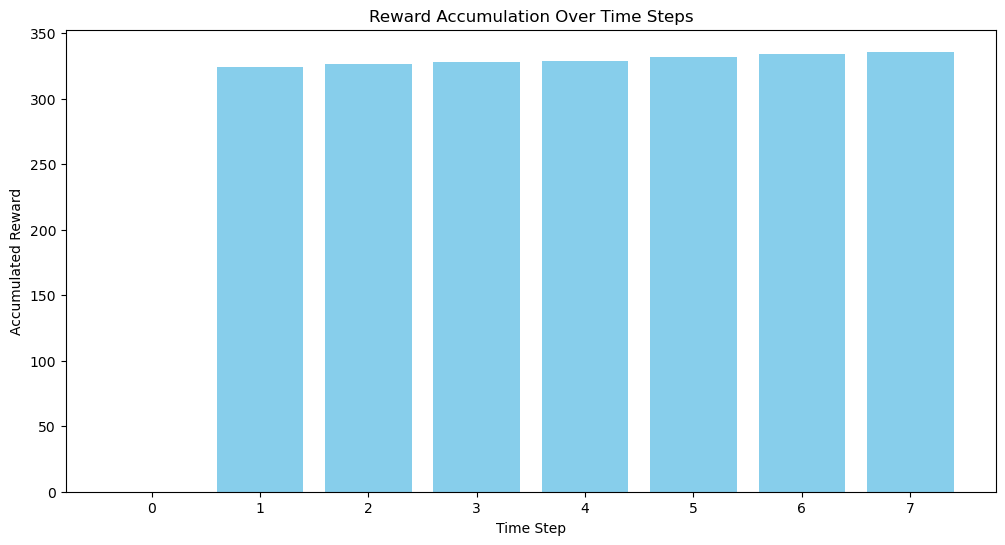

In [ ]:
reward_values = global_reward.flatten()

# Define time steps as the x-axis
time_steps = list(range(0, len(reward_values)))

# Plotting the reward as a histogram
plt.figure(figsize=(12, 6))
plt.bar(time_steps, reward_values, color='skyblue')
plt.xlabel("Time Step")
plt.ylabel("Accumulated Reward")
plt.title("Reward Accumulation Over Time Steps")
plt.show()

In [ ]:
print(len(tasks))
print(tasks)

4770
[Task(ID: 1, Type: BM, Location: (0, 0), Priority: 2, Period: 10), Task(ID: 2, Type: FT, Location: (0, 0), Priority: 3, Period: 2), Task(ID: 3, Type: BM, Location: (0, 1), Priority: 2, Period: 10), Task(ID: 4, Type: FT, Location: (0, 1), Priority: 3, Period: 2), Task(ID: 5, Type: BM, Location: (0, 2), Priority: 2, Period: 10), Task(ID: 6, Type: FT, Location: (0, 2), Priority: 3, Period: 2), Task(ID: 7, Type: BM, Location: (0, 3), Priority: 2, Period: 10), Task(ID: 8, Type: FT, Location: (0, 3), Priority: 3, Period: 2), Task(ID: 9, Type: BM, Location: (0, 4), Priority: 2, Period: 10), Task(ID: 10, Type: FT, Location: (0, 4), Priority: 3, Period: 2), Task(ID: 11, Type: BM, Location: (0, 5), Priority: 2, Period: 10), Task(ID: 12, Type: FT, Location: (0, 5), Priority: 3, Period: 2), Task(ID: 13, Type: BM, Location: (0, 6), Priority: 2, Period: 10), Task(ID: 14, Type: FT, Location: (0, 6), Priority: 3, Period: 2), Task(ID: 15, Type: BM, Location: (0, 7), Priority: 2, Period: 10), Task(

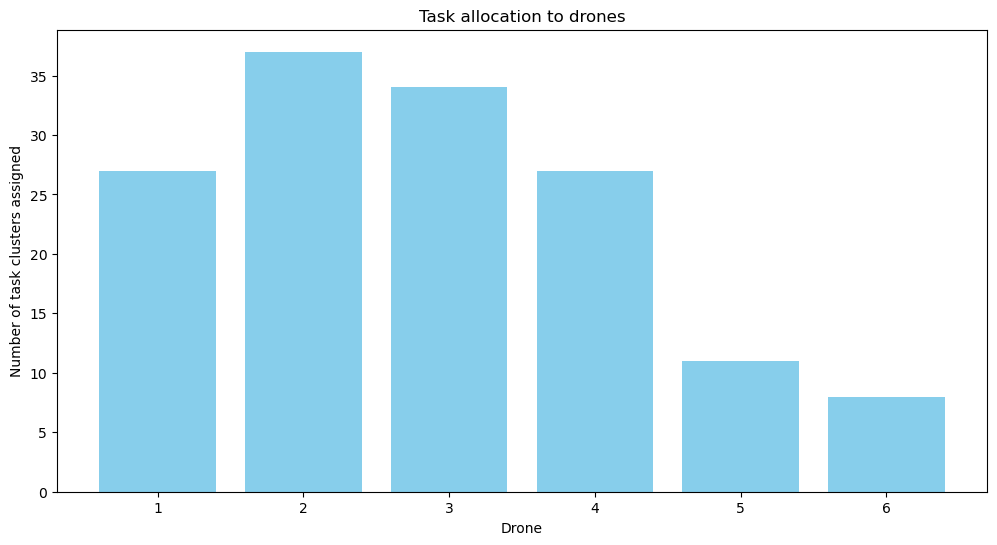

In [ ]:
tasks_assigned = []
for drone in drones:
    tasks_assigned.append(len(T[drone]))

idx = range(1,7)

# Plotting the reward as a histogram
plt.figure(figsize=(12, 6))
plt.bar(idx, tasks_assigned, color='skyblue')
plt.xlabel("Drone")
plt.ylabel("Number of task clusters assigned")
plt.title("Task allocation to drones")
plt.show()